# Declaring target feature

In [ ]:
target_features = ['GrainYield']
# target_features = ['Days2Maturity']

# Importing Libraries

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
from copy import copy
from datetime import datetime as dt

# Dictionaries
import json
from pprint import pprint

# Iterate in loops
import itertools
from itertools import zip_longest

# Simpsons integration
from numpy import trapz
from scipy.integrate import simps

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# To display df nicely in loops
from IPython.display import display 
# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',100)

# # For displaying max rows in series
# pd.options.display.max_rows = 10

# Importing data

In [ ]:
# Prints the current working directory
os.getcwd()
# os.listdir()

## Finding Username folder to make general path for multi PC use

In [ ]:
username = str(os.getcwd()).split('\\')[2]
user_path = r'C:/Users/'+username+'/'
username, user_path

## Declaring Import paths

In [ ]:
main_path = r'./Data/'
path = r'./Data/3. merged data/'
if target_features[0] == 'GrainYield':
    export_path = './Data/4. results/'
    export_path_comparability = './Data/4. results/comparability/'
elif target_features[0] == 'Days2Maturity':
    export_path = './Data/4. results_dm/'
    export_path_comparability = './Data/4. results_dm/comparability/'

# Create export_path folder if not exists already
os.makedirs(path, exist_ok=True)
os.makedirs(export_path, exist_ok=True)
os.makedirs(export_path_comparability, exist_ok=True)

# os.listdir(path)

In [ ]:
# Making dictionary of files in each folder, in case there are multiple types of data
dict_paths = {}
def explore(starting_path):
    for dirpath, dirnames, filenames in os.walk(starting_path):
        dict_paths[dirpath.split('/')[-2]] = filenames
#     pprint(dict_paths)
explore(path)

# Data Preparation
## Creating list of complete files

In [ ]:
# Get the list of all files in directory tree at given path

files_with_address = []
files_list = []

for (dirpath, dirnames, filenames) in os.walk(path):
    files_with_address += [os.path.join(dirpath, file) for file in filenames]
    files_list.extend(filenames)
    
print(len(files_with_address), 'files found in the directory')
# files_with_address
# files_list

## Data Checking/control

### Check for duplicate filenames

In [ ]:
print('Total number of files are :', len(files_list))
print('Number of unique file names are:', len(set(files_list)))
print('There is/are', len(files_list) - len(set(files_list)),'duplicate file name/names.')
if len(files_list) - len(set(files_list)) > 0:
    raise NameError

# Importing data files to Pandas

In [ ]:
all_df = []
for data in files_with_address:
    file_name = os.path.splitext(os.path.basename(data))[0]

    # Replce all invalid characters in the name
    file_name = file_name.replace(" ", "_")
    file_name = file_name.replace("-", "_")
    file_name = file_name.replace(")", "")
    file_name = file_name.replace("(", "")
    df_name = file_name.replace(".", "")
    # Test: Check if the same date is already present in the current dict key
    if df_name in all_df:
        print(f'A file with the same name {df_name} has already been imported. \n Please check if there is duplication of data.')
        raise NameError
    all_df.append(df_name)

    locals()[df_name] = pd.read_csv(data, index_col=False)
    print(df_name, '=====', locals()[df_name].shape)
# all_df

In [ ]:
print(f'Total imported {len(all_df)}')
# all_df

# Finding yield columns

## Importing Weather variables, yield columns, spectral indices, base indices columsn list

In [ ]:
a_file = open(main_path+'vollebekk_weather_columns.json', "r")
output_str = a_file.read()
# The file is imported as string
# Converting it to python format
weather_cols_vollebekk = json.loads(output_str)
a_file.close()
pprint(len(weather_cols_vollebekk))

In [ ]:
a_file = open(main_path+'staur_weather_columns.json', "r")
output_str = a_file.read()
# The file is imported as string
# Converting it to python format
weather_cols_staur = json.loads(output_str)
a_file.close()
pprint(len(weather_cols_staur))

In [ ]:
a_file = open(main_path+"yield_columns.json", "r")
output_str = a_file.read()
# The file is imported as string
# Converting it to python format
yield_cols = json.loads(output_str)
a_file.close()
print(yield_cols)

In [ ]:
a_file = open(main_path+"spectral_indices_columns.json", "r")
output_str = a_file.read()
# The file is imported as string
# Converting it to python format
spectral_indices_all = json.loads(output_str)
a_file.close()
print(spectral_indices_all)

In [ ]:
a_file = open(main_path+"base_indices_columns.json", "r")
output_str = a_file.read()
# The file is imported as string
# Converting it to python format
base_indices = json.loads(output_str)
a_file.close()
print(base_indices)

## XXXXXX Defining categories of features

In [ ]:
# ToDo: Add check for duplicate columns in the df
base_indices
spectral_indices_all 
drop_indices = ['EVI', 'GLI', 'MTCI']
spectral_indices = [x for x in spectral_indices_all if x not in drop_indices]

# Staur weather columns are all also present in Vollebekk weather so they can be use as general weather features
weather_features = weather_cols_staur.copy()
environment_var = weather_features + ['Staur_Env', 'Vollebekk_Env']
# yield_cols

# Dropping DF which donot have the Target Feature

In [ ]:
# Dropping unnecessary columns
all_df_dm = []
for df in all_df:
    temp_df = locals()[df].copy()
    if target_features[0] in temp_df.columns.tolist():
        all_df_dm.append(df)
#         print(df)

In [ ]:
all_df_simps = [x for x in all_df_dm if 'Simps' in x]
all_df_trapz = [x for x in all_df_dm if 'Trapz' in x]
# all_df_simps, all_df_trapz

# Dropping unnecessary columns


In [ ]:
# Dropping unnecessary columns

for df in all_df_dm:
    temp_df = locals()[df].copy()
    locals()[df] = temp_df[base_indices+spectral_indices_all+environment_var+['Name',target_features[0]]]
    print(df, temp_df.shape, '==>', locals()[df].shape)


# Dealing with Nan values

## Dropping Missing values

In [ ]:
# Dropping rows with missing value in any column

for df in all_df_dm:
    temp_df = locals()[df].copy()
    locals()[df] = temp_df.dropna(axis=0)
    print(temp_df.shape[0] - locals()[df].shape[0], ' rows dropped in ', df)
#     print(locals()[df].shape[0])

# Normalizing the data using Z-Score from scipy

In [ ]:
from scipy.stats import zscore

for df in all_df_dm:
    temp_df = locals()[df].copy()
    for col in temp_df.columns:
        # Checking if the column is not a yield column
        if col not in yield_cols+environment_var:
            temp_df[col] = zscore(temp_df[col])
    locals()[df] = temp_df.copy()
    print(df)

# Importing functions 

In [ ]:
from functions.save_results import save_results, save_grid_results
from functions.split_data import list_test_train_df, data_prep_field
from functions.regression import training_regr, training_gkf_std, grid
from functions.plot_featimp import plot_feat_imp

# ML Models

In [ ]:
import time
# Pre.Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
# from sklearn.model_selection import StratifiedGroupKFold
# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Metrices
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## XXXXXX Parameters

In [ ]:
threshold_all = 'top_25'
sort_feature_imp = True
show_feat_imp_plot = True
save_feat_imp_plot = True
save_results_now = True
agg_method = 'Simpsons'
# agg_method = 'Trapezoid'

In [ ]:
# training_features = base_indices + spectral_indices_all + environment_var
training_features = base_indices + spectral_indices_all + weather_features
# training_features =  base_indices + spectral_indices + weather_features
# training_features =  spectral_indices + weather_features
# training_features = spectral_indices

target_features

group_feature = ['Name']

if agg_method == 'Simpsons':
    all_df_now = all_df_simps.copy()
elif agg_method == 'Trapezoid': 
    all_df_now = all_df_trapz.copy()

## Fine Tuning the models using all data

### All data mixed

In [ ]:
temp_list = [x for x in all_df_now if not 'Robot' in x]

# Making list of df for conct before training
# This is different form list of srtings, as this is a list of actual dataframes
df_list = []
for x in temp_list:
    df_list.append(locals()[x])

# Conct all df to one df    
df_ = pd.concat(df_list).reset_index(drop=True)

# Shuffeling all the items/rows
df_shuffle = df_.sample(frac=1, random_state=1).reset_index(drop=True)

X = df_shuffle[training_features+['Name']]
y = df_shuffle[target_features].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

groups = X_train[group_feature].values.ravel()

X_train = X_train.drop(['Name'], axis=1).values
X_test = X_test.drop(['Name'], axis=1).values

gkf = list(GroupKFold(n_splits=6).split(X_train, y_train, groups))

In [ ]:
from sklearn.svm import SVR

model = SVR(verbose=15)
model.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR

# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

scores = ["r2", "neg_mean_squared_error"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVR(), tuned_parameters, scoring=score, n_jobs=-1, verbose = 10)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for r2

Fitting 5 folds for each of 12 candidates, totalling 60 fits


### RandomForestRegressor

In [27]:
# # ==============================================================================
# # RandomForestRegressor
# # ==============================================================================
# from sklearn.ensemble import RandomForestRegressor

# results_RF = pd.DataFrame()
# sc = StandardScaler()

# for max_features in ['auto', 'sqrt']:
#     for max_depth in [None]+[int(x) for x in np.linspace(10, 110, num=11)]:
#         #         for n_estimators in [int(x) for x in np.linspace(start=10, stop=1000, num=10)]:
#         for min_samples_split in [2, 5, 10]:
#             for min_samples_leaf in [1, 2, 4]:
#                 model = RandomForestRegressor(max_features=max_features,
#                                               max_depth=max_depth,
# #                                                   n_estimators=n_estimators,
#                                               min_samples_split=min_samples_split,
#                                               min_samples_leaf=min_samples_leaf,
#                                               random_state=1)
#                 pipe = Pipeline(steps=[('sc', sc), ('model', model)])
#                 print('Training model', model)
#                 pipefit = pipe.fit(X_train, y_train)
#                 print('Making predictions')
#                 pred_test = pipefit.predict(X_test)
#                 test_score = r2_score(y_test, pred_test)
#                 pred_train = pipefit.predict(X_train)
#                 train_score = r2_score(y_train, pred_train)
#                 print('R2 Train:', train_score, '      R2 Test:', test_score)
#                 list_zip = list(zip([model],
#                                     [pipe],
#                                     [train_score],
#                                     [test_score],

#                                     [max_features],
#                                     [max_depth],
#                                     [min_samples_split],
#                                     [min_samples_leaf]))
#                 results_RF = results_RF.append(pd.DataFrame(list_zip))
# #                 save_grid_results(list_zip,  features_all=[training_features,
# #                                                            base_indices,
# #                                                            spectral_indices_all,
# #                                                            spectral_indices,
# #                                                            weather_features, export_path])

### Lasso

In [28]:
# # ==============================================================================
# # Lasso
# # ==============================================================================
# from sklearn.linear_model import Lasso

# results_LS = pd.DataFrame()

# sc = StandardScaler()

# for alpha in [0]:
#     for max_iter in [50000000]:
#         for selection in ['random']:
#             model = Lasso(alpha=alpha,
#                           max_iter=max_iter,
#                           selection=selection,
#                           warm_start=True,
#                           random_state=1
#                           )
#             pipe = Pipeline(steps=[('sc', sc), ('model', model)])
#             print('Training model', model)
#             pipefit = pipe.fit(X_train, y_train)
#             print('Making predictions')
#             pred_test = pipefit.predict(X_test)
#             test_score = r2_score(y_test, pred_test)
#             pred_train = pipefit.predict(X_train)
#             train_score = r2_score(y_train, pred_train)
#             print('R2 Train:', train_score, '      R2 Test:', test_score)
#             list_zip = list(zip([model],
#                                 [pipe],
#                                 [train_score],
#                                 [test_score],
                                
#                                 [alpha],
#                                 [max_iter],
#                                 [selection]))
#             results_LS = results_LS.append(pd.DataFrame(list_zip))
# #                 save_grid_results(list_zip,  features_all=[training_features,
# #                                                            base_indices,
# #                                                            spectral_indices_all,
# #                                                            spectral_indices,
# #                                                            weather_features, export_path])

In [29]:
# # plt.plot( results_LS.iloc[:500,3], results_LS.iloc[:500,2])
# plt.plot( results_LS.iloc[:,4], results_LS.iloc[:,2])

# # plt.show()

### LinearRegression

In [30]:
# # ==============================================================================
# # LinearRegression
# # ==============================================================================
# from sklearn.linear_model import LinearRegression


# results_LR = pd.DataFrame()

# sc = StandardScaler()

# for normalize in [True, False]:
#     for copy_X in [True, False]:
#         for positive in [True, False]:
#             for fit_intercept in [True, False]:
#                 model = LinearRegression(
# #                     normalize=normalize,
# #                     copy_X=copy_X,
# #                     positive=positive,
# #                     fit_intercept=fit_intercept,
#                 )
#                 pipe = Pipeline(steps=[('sc', sc), ('model', model)])
#                 print('Training model', model)
#                 pipefit = pipe.fit(X_train, y_train)
#                 print('Making predictions')
#                 pred_test = pipefit.predict(X_test)
#                 test_score = r2_score(y_test, pred_test)
#                 pred_train = pipefit.predict(X_train)
#                 train_score = r2_score(y_train, pred_train)
#                 print('R2 Train:', train_score, '      R2 Test:', test_score)
#                 list_zip = list(zip([model],
#                                     [pipe],
#                                     [train_score],
#                                     [test_score],
                                    
#                                     [normalize],
#                                     [copy_X],
#                                     [positive],
#                                     [fit_intercept]))
#                 results_LR = results_LR.append(pd.DataFrame(list_zip))
# #                 save_grid_results(list_zip,  features_all=[training_features,
# #                                                            base_indices,
# #                                                            spectral_indices_all,
# #                                                            spectral_indices,
# #                                                            weather_features, export_path])

### Feature Selection

In [31]:
# from sklearn.feature_selection import SelectPercentile
# from sklearn.feature_selection import f_regression
# # X, y = load_iris(return_X_y=True)
# X_te = X.drop(['Name'], axis=1)

# X_new = SelectPercentile(f_regression, percentile=95).fit_transform(X_te, y)
# X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=1)
# X_new.shape


## List of Final models

### SKLearn Models

In [32]:
models = [
    LinearRegression(),
    RandomForestRegressor(n_jobs=-1, random_state=1),
    GradientBoostingRegressor(random_state=1),
    # No overfitting
    RandomForestRegressor(n_estimators=50,
                          max_depth=100,
                          min_samples_split=400,
                          n_jobs=-1, random_state=1),
# #     Same results as default model but a tiny bit less overfiting
#     RandomForestRegressor(n_estimators=230,
#                           max_depth=20,
#                           min_samples_leaf=2,
#                           n_jobs=-1, random_state=1),
    Lasso(alpha=0, max_iter=50000, random_state=1, selection='random')
]

## Variations in Datasets

### All data mixed

RandomForestRegressor(n_jobs=-1, random_state=1)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=1))])
 RMSE Test: 3.66        R2 Test: 0.87
RMSE Train: 1.31       R2 Train: 0.98


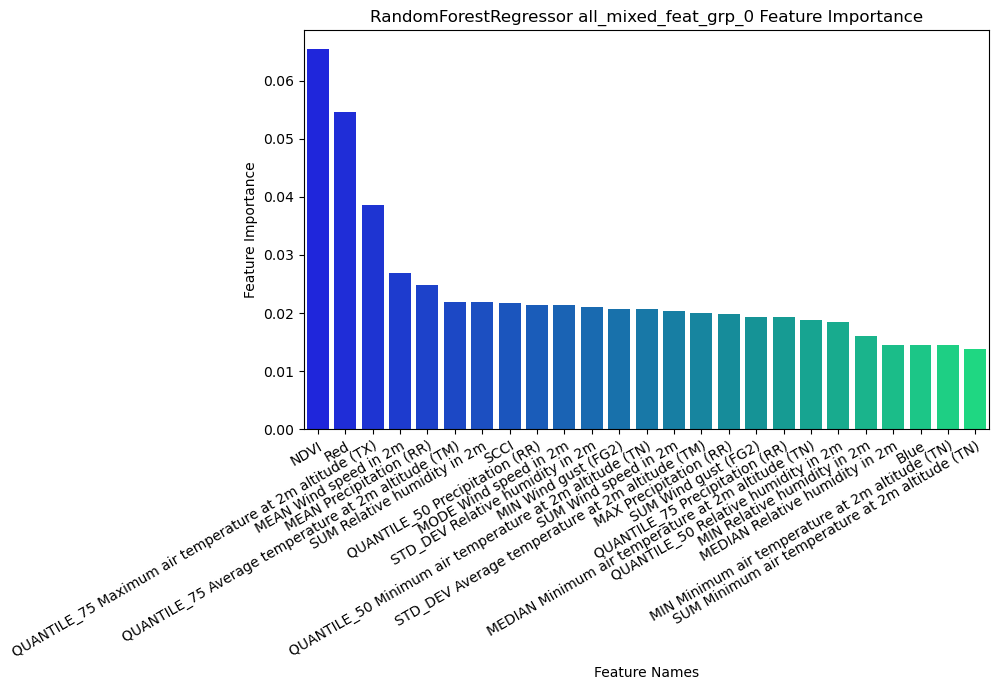

In [33]:
temp_list = [x for x in all_df_now if not 'Robot' in x]

# Making list of df for conct before training
# This is different form list of srtings, as this is a list of actual dataframes
df_list = []
for x in temp_list:
    df_list.append(locals()[x])

df_ = pd.concat(df_list)

# Shuffeling all the items
df_shuffle = df_.sample(frac=1, random_state=1).reset_index(drop=True)

X = df_shuffle[training_features]
y = df_shuffle[target_features].values.ravel()
groups = df_shuffle[group_feature].values.ravel()

gkf = list(GroupKFold(n_splits=6).split(X, y, groups))
# gkf = list(StratifiedGroupKFold(n_splits=6, shuffle=True, random_state=1).split(X, y, groups))

#     Getting scores using cross_val_score
for model in models:
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.33, random_state=1)

#     importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_regr(
#         model, X_train, y_train, X_test, y_test)

    importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_gkf_std(
        model, X, y, gkf)
    if importances is not None:
        plot_feat_imp(feature_importance=importances,
                      model=model,
                      train_feat=training_features,
                      threshold=threshold_all,
                      sort_feat=sort_feature_imp,
                      show_plot=show_feat_imp_plot,
                      save_plot=save_feat_imp_plot,
                      export_path=export_path,
                      save_suffix='all_mixed')
    if save_results_now:
        save_results(model=model,
                     agg_method=agg_method,
                     train_field='all_mix',
                     test_field='all_mix',
                     features_all=[training_features,
                                   base_indices,
                                   spectral_indices_all,
                                   spectral_indices,
                                   weather_features, export_path],
                     importances=importances,
                     RMSE_test=RMSE_test_temp,
                     RMSE_train=RMSE_train_temp,
                     R2_test=R2_test_temp,
                     R2_train=R2_train_temp,
                     GKF_CV=GKF_CV_temp)